In [1]:
import os
import sys
from glob import glob
from pathlib import Path
from tqdm import tqdm
from dotenv import load_dotenv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier




In [2]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.utils.helpers import get_emotion_abrs_from_ids

# Paths

In [4]:
load_dotenv()
output_path = os.getenv("AUDIO_OUT")
# Global configuration path
glob_conf_path = '../global_config.py'

# Load global variables

In [5]:
exec(open(glob_conf_path).read())

# Load and shuffle data

In [6]:
from sklearn.utils import shuffle

train_intensity_df = pd.read_csv(output_path + 'audio_data_egemaps_train.csv')
train_shuffled_df = shuffle(train_intensity_df, random_state=seed)
train_shuffled_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,emotion_1_id,filename,video_id,group
418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.350158,0.000000,0.449618,43,A101_sha_p_4,A101,0
343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.140063,0.000000,0.593075,27,A200_conc_p_1,A200,1
632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.226498,0.000000,0.552511,37,A101_disa_p_2,A101,0
512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.184858,0.000000,0.553816,30,A200_nos_p_1,A200,1
105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.315457,0.000000,0.453441,19,A102_ins_v_2,A102,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,0.682459,0.117735,0.667406,0.677529,0.656245,0.134158,0.056983,0.022535,0.176384,0.043100,...,0.207071,0.048689,0.197418,0.049422,0.253354,0.676849,25,A102_pea_p_3,A102,0
1317,0.809127,0.228207,0.782361,0.790750,0.788018,0.211168,0.051594,0.003829,0.140771,0.066234,...,0.172935,0.109551,0.251047,0.050852,0.359722,0.775907,20,A102_tri_p_2,A102,0
752,0.616353,0.194402,0.604902,0.614279,0.599872,0.136221,0.069463,0.023832,0.177081,0.054428,...,0.458385,0.101124,0.062252,0.006467,0.051345,0.778588,17,A200_dist_p_1,A200,1
543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.245426,0.000000,0.352454,41,A101_pri_v_3,A101,0


# Other functions

In [7]:
from sklearn.metrics import confusion_matrix

def calculate_conf_matrix(X_train, X_val, y_train, y_val, clf):
    # train classifier on training sets 
    clf.fit(X_train,y_train)

    # Compute results (validation dataset)    
    y_pred = clf.predict(X_val)                       # Predict class

    # compare true validation results (y_val) with prediction (y_pred)
    # Compute confusion matrix
    return confusion_matrix(y_val,
                            y_pred,
                            normalize='true'
                            )
    

In [8]:
def iterate_conf_matrices(size, X, y, cv, clf):
    # Initialize a matrix of zeros to store results
    conf_mat_avg = np.zeros([size, size])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        conf_mat_avg += calculate_conf_matrix(X_train, X_val, y_train, y_val, clf)
    
    # compute the average scores by dividing with number of groups
    return conf_mat_avg/n_groups

In [9]:
def get_conf_matrix(X, y, cv, clf):
    """
    Produces a confusion matrix by iterating and averageing the confusion matrix for each validation set
    :return: confusion matrix in the form of a dataframe
    """
    # get emotion_ids
    emotion_ids = y.unique()
    
    # compute the average scores by dividing with number of groups
    conf_mat_avg = iterate_conf_matrices(len(emotion_ids), X, y, cv, clf,)
    
    # get emotion abreviations
    emotion_abrs = get_emotion_abrs_from_ids(emotion_ids)
    
    # create dataframe with lists of emotion ids as row and column names
    df_cm = pd.DataFrame(conf_mat_avg, list(emotion_abrs), list(emotion_abrs))
    
    # sort columns
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    return df_cm

In [10]:
def plot_conf_matrix(df_cm, title):
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)

In [11]:
def save_conf_matrix(file_name):
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')       

# Define scoring function

In [12]:
def evaluate_scores(X, y, groups, clf, scoring_method):
    # get scores
    scores = cross_validate(X=X, y=y,
                            estimator           = clf,
                            scoring             = [scoring_method],
                            cv                  = logo.split(X=X,groups=groups),
                            verbose             = 1,
                            n_jobs              = -1,
                            return_train_score  = True                        
                           )
    
    print('\nprinting {} measures'.format(scoring_method))
    print('avg (train):', np.mean(scores['train_{}'.format(scoring_method)]))
    print('std (train):', np.std(scores['train_{}'.format(scoring_method)]))
    print('avg (validation):', np.mean(scores['test_{}'.format(scoring_method)]))
    print('std (validation):', np.std(scores['test_{}'.format(scoring_method)]))

# Training and testing

### Get X, y and groups from the training data set

In [13]:
# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=["filename", "video_id", "emotion_1_id", "group"])
y = train_shuffled_df.emotion_1_id
groups = train_shuffled_df.group
n_groups = len(groups.unique())

# Elastic Net SGD Classifier

### Cross validate with best parameters

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



printing accuracy measures
avg (train): 0.18161701918024173
std (train): 0.03855343536521283
avg (validation): 0.030835358644245928
std (validation): 0.003846722280609562


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



printing roc_auc_ovo_weighted measures
avg (train): nan
std (train): nan
avg (validation): nan
std (validation): nan


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s finished



printing recall_macro measures
avg (train): 0.16524621212121213
std (train): 0.02320075757575757
avg (validation): 0.04053030303030303
std (validation): 0.004924242424242425


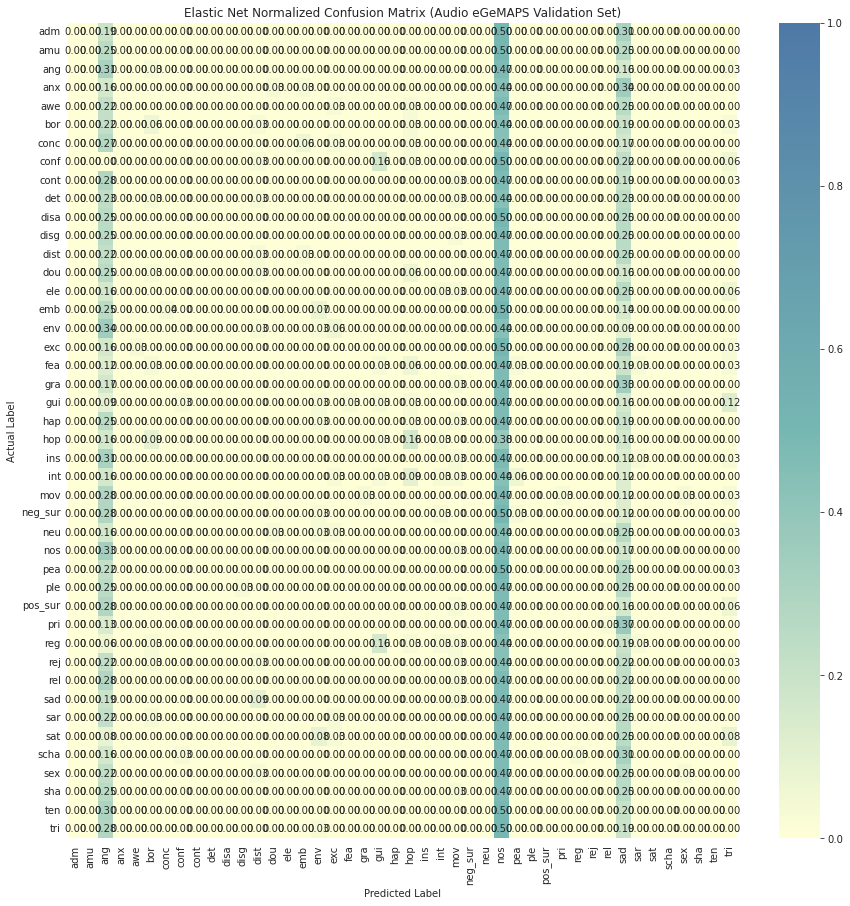

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

logo = LeaveOneGroupOut()

# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

evaluate_scores(X, y, groups, clf, 'accuracy')
evaluate_scores(X, y, groups, clf, 'roc_auc_ovo_weighted')
evaluate_scores(X, y, groups, clf, 'recall_macro')

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )

# Plot confusion matrix
plot_conf_matrix(df_cm, title='Elastic Net Normalized Confusion Matrix (Audio eGeMAPS Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_elastic_net_egemaps_audio.svg')


## kNN

TODO: Might be smart to seed such that every emotion has it's own cluster starting point

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



printing accuracy measures
avg (train): 0.32538672490803994
std (train): 0.019988997635312644
avg (validation): 0.030859990803993695
std (validation): 0.006712263531266423


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished



printing roc_auc_ovo_weighted measures
avg (train): 0.9651026632718023
std (train): 0.0012096680947408234
avg (validation): 0.5174875333050168
std (validation): 0.002160367395300289

printing recall_macro measures
avg (train): 0.32609577922077926
std (train): 0.020698051948051938
avg (validation): 0.03068181818181818
std (validation): 0.0065340909090909095


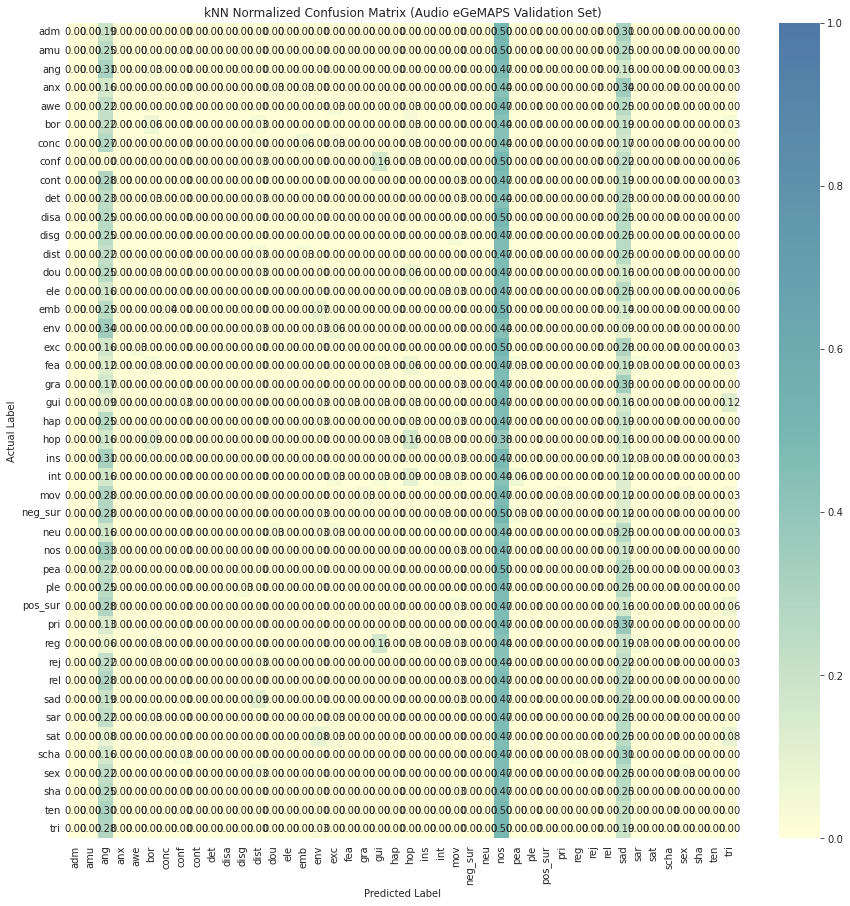

In [15]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_knn_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

evaluate_scores(X, y, groups, clf, 'accuracy')
evaluate_scores(X, y, groups, clf, 'roc_auc_ovo_weighted')
evaluate_scores(X, y, groups, clf, 'recall_macro')

# Plot confusion matrix
plot_conf_matrix(df_cm, title='kNN Normalized Confusion Matrix (Audio eGeMAPS Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_knn_egemaps_audio.svg')

## Decision Tree


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



printing accuracy measures
avg (train): 1.0
std (train): 0.0
avg (validation): 0.03157021807672097
std (validation): 0.006002036258539149


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished



printing roc_auc_ovo_weighted measures
avg (train): 1.0
std (train): 0.0
avg (validation): 0.5037575930064525
std (validation): 0.002304104634359483

printing recall_macro measures
avg (train): 1.0
std (train): 0.0
avg (validation): 0.031486742424242424
std (validation): 0.0030776515151515176


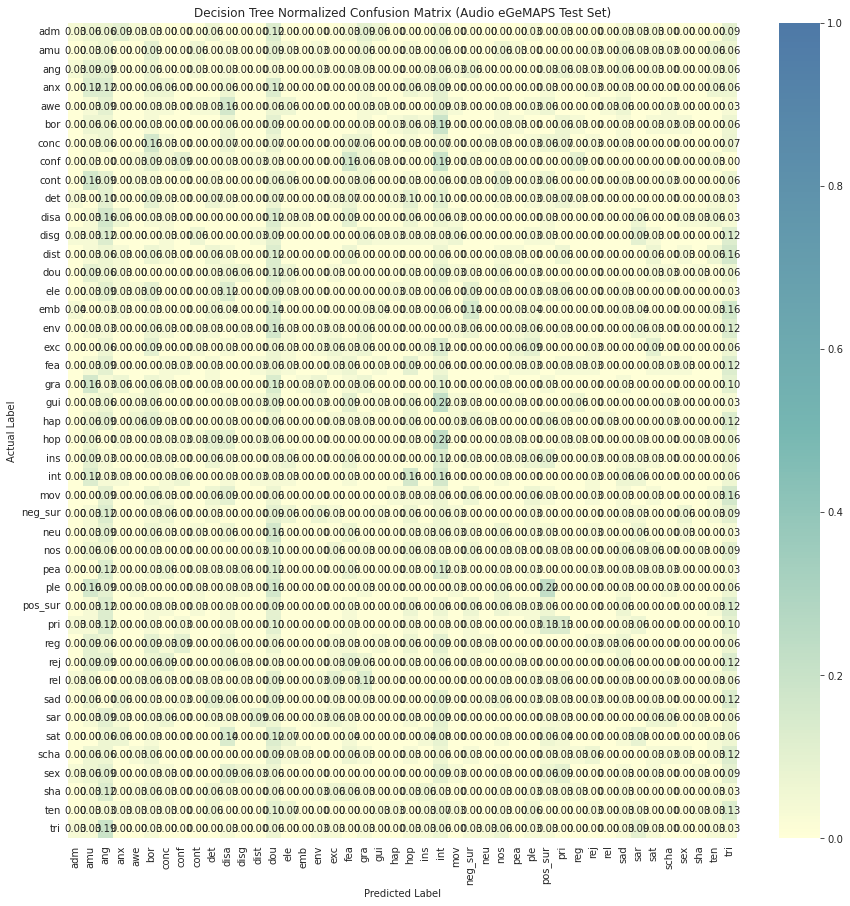

In [16]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_decision_tree_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

evaluate_scores(X, y, groups, clf, 'accuracy')
evaluate_scores(X, y, groups, clf, 'roc_auc_ovo_weighted')
evaluate_scores(X, y, groups, clf, 'recall_macro')

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Decision Tree Normalized Confusion Matrix (Audio eGeMAPS Test Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_tree_egemaps_audio.svg')

## Random Forest

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



printing accuracy measures
avg (train): 1.0
std (train): 0.0
avg (validation): 0.04942442853389385
std (validation): 0.00029148055701523623


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



printing roc_auc_ovo_weighted measures
avg (train): 1.0
std (train): 0.0
avg (validation): 0.5663899819144572
std (validation): 0.011709708064034485


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s finished



printing recall_macro measures
avg (train): 1.0
std (train): 0.0
avg (validation): 0.04862689393939394
std (validation): 0.0025094696969696975


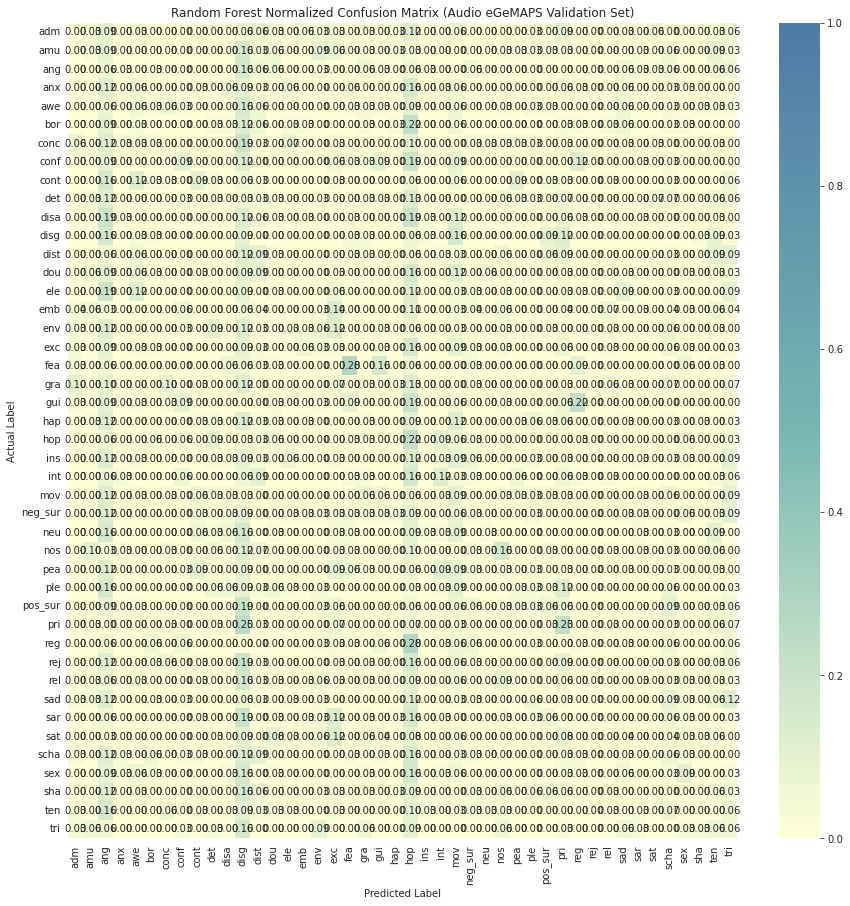

In [17]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

evaluate_scores(X, y, groups, clf, 'accuracy')
evaluate_scores(X, y, groups, clf, 'roc_auc_ovo_weighted')
evaluate_scores(X, y, groups, clf, 'recall_macro')

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Random Forest Normalized Confusion Matrix (Audio eGeMAPS Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_rf_egemaps_audio.svg')